## Setup

In [47]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
%%javascript
// Disable auto-scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [56]:
%%R

install.packages("tidycensus")


The downloaded binary packages are in
	/var/folders/nf/hzs770c17vb39slzt00kvk040000gn/T//RtmpcRPi92/downloaded_packages


trying URL 'https://cran.wustl.edu/bin/macosx/big-sur-x86_64/contrib/4.4/tidycensus_1.7.1.tgz'
Content type 'application/x-gzip' length 3554550 bytes (3.4 MB)
downloaded 3.4 MB



## TidyCensus Example

This notebook grabs data from the US Census using the [tidycensus package in R](https://walker-data.com/tidycensus/index.html). Make sure you have installed the `tidyverse` and `tidycensus` packages.

In [57]:
%%R 

library(tidycensus)
library(tidyverse)

# store any shapefiles we grab from the census in ~/Library/Caches/tigris
# in case the government removes the shapefiles FTP server again 😭
options(tigris_use_cache = TRUE)

In [58]:
!pip install python-dotenv



[notice] A new release of pip is available: 24.0 -> 25.0
[notice] To update, run: pip install --upgrade pip


### Step 1 \| Get a Census API key

Get a Census API key [here](https://api.census.gov/data/key_signup.html).

Then make a new file called `.env` in this folder and put it in there. 

The `.env` file should look like this:

```bash
CENSUS_API_KEY="your-api-key-here"
```

This is what is known as an environment variable. We load it below in Python

In [59]:
from dotenv import load_dotenv
load_dotenv() # <- searches for a file named .env and loads the environment variables in it

True

In [60]:
%%R 
# passes the CENSUS_API_KEY environment variable we loaded
# in Python above to R (specifically to the tidycensus package)
census_api_key(Sys.getenv("CENSUS_API_KEY"))

To install your API key for use in future sessions, run this function with `install = TRUE`.


### Step 2 \| Figure out what tables you want data from and at what geographic granularity

Use <https://censusreporter.org/> to figure out which tables you want.

-   Scroll to the bottom of the page to see the tables.
-   If you already know the table ID, stick that in the "Explore" section to learn more about that table.

Once you've found the variable or variables you want, you can plug them into this code under `variables`. 

In [61]:
%%R 

# the variable B01003_001 was selectd from the census table 
# for population, which we found in censusreporter here:
# https://censusreporter.org/tables/B01003/


# Here are the various geographies you can use with tidycensus
# https://walker-data.com/tidycensus/articles/basic-usage.html#geography-in-tidycensus

# Get variable from ACS
nyc_census_data <- get_acs(geography = "tract", 
                      state='NY',
                      county = c("New York", "Kings", "Queens", "Bronx", "Richmond"),
                      variables = c(
                        population="B01003_001",
                        total_units = "B25001_001",
                        med_inc="B19013_001"
                      ), 
                      year = 2021,
                      survey="acs5",
                      geometry=T)

nyc_census_data


Simple feature collection with 6981 features and 5 fields (with 3 geometries empty)
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -74.25609 ymin: 40.4961 xmax: -73.70036 ymax: 40.91771
Geodetic CRS:  NAD83
First 10 features:
         GEOID                                       NAME    variable estimate
 36081014700  Census Tract 147, Queens County, New York  population     2863
 36081014700  Census Tract 147, Queens County, New York     med_inc    71815
 36081014700  Census Tract 147, Queens County, New York total_units     1570
 36047058400   Census Tract 584, Kings County, New York  population     3655
 36047058400   Census Tract 584, Kings County, New York     med_inc    67315
 36047058400   Census Tract 584, Kings County, New York total_units     1498
 36061006900 Census Tract 69, New York County, New York  population     2450
 36061006900 Census Tract 69, New York County, New York     med_inc   237500
 36061006900 Census Tract 69, New York County, New York tot

Getting data from the 2017-2021 5-year ACS
Using FIPS code '36' for state 'NY'
Using FIPS code '061' for 'New York County'
Using FIPS code '047' for 'Kings County'
Using FIPS code '081' for 'Queens County'
Using FIPS code '005' for 'Bronx County'
Using FIPS code '085' for 'Richmond County'


### Step 3 | Pivot to Wide Format

Pivot from long to wide using `pivot_wider`.

Depending on what you're trying to do, you may want the data in long or wide format. This example pivots the data to wide format, which will help us with mapping later on in the notebook.

In [62]:
%%R 

nyc_census_data <- nyc_census_data %>% 
  pivot_wider(
    names_from=variable, 
    values_from = c(estimate, moe),
    names_glue = "{variable}_{.value}"
  )# pivot from wide to long

nyc_census_data

Simple feature collection with 2327 features and 8 fields (with 1 geometry empty)
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -74.25609 ymin: 40.4961 xmax: -73.70036 ymax: 40.91771
Geodetic CRS:  NAD83
# A tibble: 2,327 × 9
   GEOID    NAME                   geometry population_estimate med_inc_estimate
   <chr>    <chr>        <MULTIPOLYGON [°]>               <dbl>            <dbl>
 1 3608101… Cens… (((-73.9137 40.76548, -7…                2863            71815
 2 3604705… Cens… (((-73.96103 40.59616, -…                3655            67315
 3 3606100… Cens… (((-74.02064 40.73039, -…                2450           237500
 4 3604707… Cens… (((-73.93345 40.6257, -7…                2676           117857
 5 3604710… Cens… (((-73.90735 40.63083, -…                3004            76207
 6 3604705… Cens… (((-73.96279 40.72256, -…                1834           107410
 7 3600502… Cens… (((-73.92012 40.83759, -…                4030            37200
 8 3608104… Cens… (((-73

### Step 4 | Do calculations with `mutate`

In R, you can use `mutate` to create new columns or modify existing ones.

In this example, we create a column called `borough` by extracting the borough from the `NAME` column.

_(hint, I used GitHub Copilot -- a tool similar to ChatGPT -- to do this...see my prompt in the comments)_

In [63]:
%%R 

# Extract borough name from NAME by splitting strings like "Census Tract 147, Queens County, New York" 
# on commas and extracting the second to last element

nyc_census_data <- nyc_census_data %>% 
    mutate(
        borough = str_split(NAME, ",") %>% map_chr(2) %>% str_trim(),
        units_per_person = total_units_estimate / population_estimate
    ) 

nyc_census_data

Simple feature collection with 2327 features and 10 fields (with 1 geometry empty)
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -74.25609 ymin: 40.4961 xmax: -73.70036 ymax: 40.91771
Geodetic CRS:  NAD83
# A tibble: 2,327 × 11
   GEOID    NAME                   geometry population_estimate med_inc_estimate
 * <chr>    <chr>        <MULTIPOLYGON [°]>               <dbl>            <dbl>
 1 3608101… Cens… (((-73.9137 40.76548, -7…                2863            71815
 2 3604705… Cens… (((-73.96103 40.59616, -…                3655            67315
 3 3606100… Cens… (((-74.02064 40.73039, -…                2450           237500
 4 3604707… Cens… (((-73.93345 40.6257, -7…                2676           117857
 5 3604710… Cens… (((-73.90735 40.63083, -…                3004            76207
 6 3604705… Cens… (((-73.96279 40.72256, -…                1834           107410
 7 3600502… Cens… (((-73.92012 40.83759, -…                4030            37200
 8 3608104… Cens… (((-

### Step 5 | Example Plots

Let's practice with histograms

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: Removed 88 rows containing non-finite outside the scale range (`stat_bin()`). 



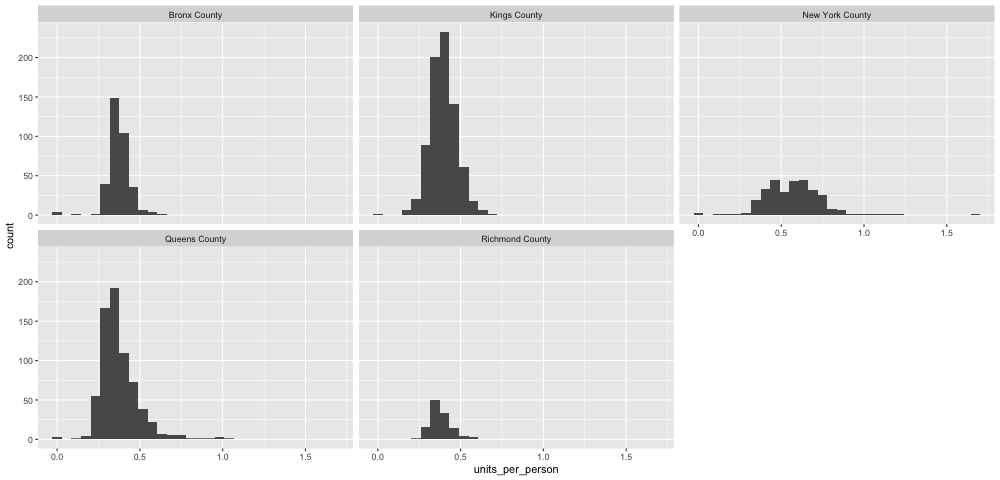

In [64]:
%%R -w 1000

ggplot(nyc_census_data) + 
    aes(x=units_per_person) +
    geom_histogram() + 
    facet_wrap(~borough) 

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Removed 88 rows containing non-finite outside the scale range
(`stat_boxplot()`). 

R[write to console]: 2: Removed 85 rows containing missing values or values outside the scale range
(`geom_point()`). 



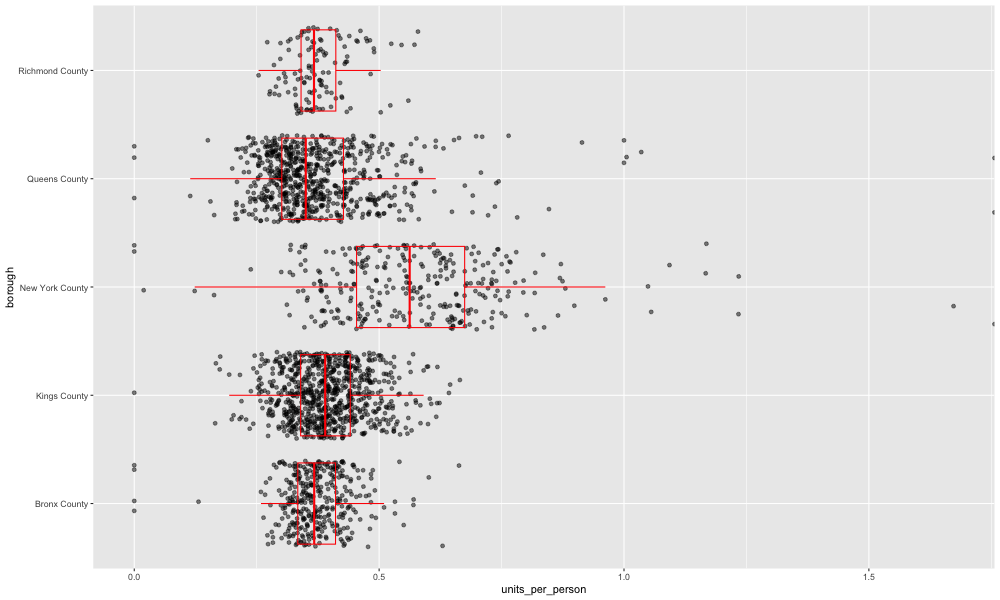

In [65]:
%%R -w 1000 -h 600

ggplot(nyc_census_data) + 
    aes(x=units_per_person, y=borough) +
    geom_jitter(alpha=0.5) + 
    # overlay a box and whisker plot that is transparent with no outliers and is red
    geom_boxplot(fill=NA, outlier.shape=NA, color="red") 

### Step 6 \| Example Map

See more details about making maps here:

https://walker-data.com/tidycensus/articles/spatial-data.html

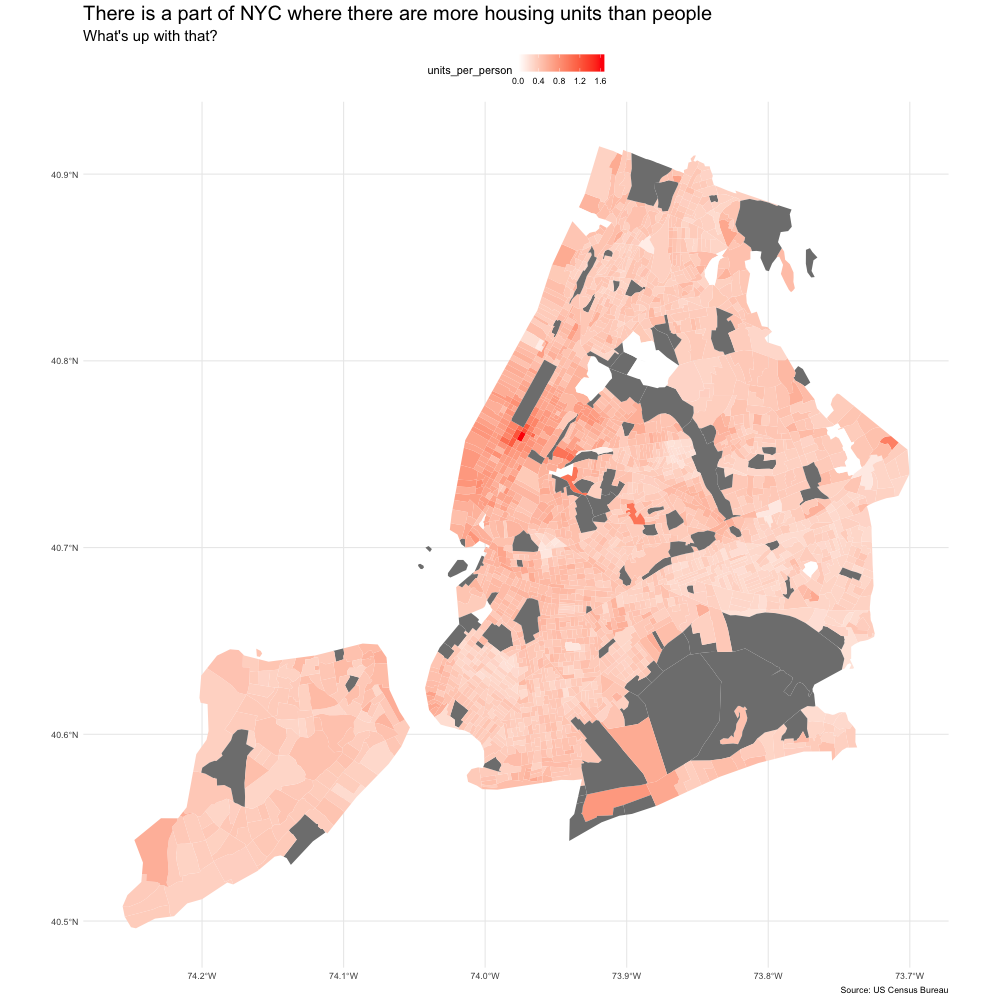

In [66]:
%%R -w 1000 -h 1000

nyc_census_data %>%
  ggplot(aes(fill = units_per_person)) + 
  geom_sf(color = NA) + 
  scale_fill_gradient(low="white", high="red") + 
  theme_minimal() +
  labs(
    title = "There is a part of NYC where there are more housing units than people",
    subtitle = "What's up with that?",
    caption = "Source: US Census Bureau"
  ) +
  theme(
    #make title and subitle bigger
    plot.title = element_text(size = 20),
    plot.subtitle = element_text(size = 15),
    # move legend to top
    legend.position = "top"
  )


## Bonus 🤔

Hmm...that map looks weird. What happened to the east river (the one that separates Queens from Manhattan). How can we fix it? Google around and see if you can find a tutorial to help you figure out the problem and fix it. Then, correct the mistake in the map above.